First import all neccessary modules

In [1]:
from datetime import datetime
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, Callback
from keras.utils import Sequence
from keras.metrics import Accuracy, Precision, Recall
from keras.optimizers import Adam, RMSprop, SGD, Nadam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import keras
from positional_encoding import PositionalEncoding, PositionalEncoding2

from preprocessor import Preprocessor
from message_encoder import *

KeyboardInterrupt: 

In [ ]:
save_artifacts = True

# Preprocessor
First we define all hyperparameters used for the preprocessor. If a preprocessor path is defined, the preprocesor will be loaded from that file instead of creating a new preprocessor since that might take a while. 

In [ ]:
# hyper parameters
# preprocessing
log_files = [i for i in range(745, 754)]            # list of ints representing the numbers of log files to use
logs_per_class = 100                                # How many datapoints per class should be collected if available
window_size = 20                                    # how many log messages to be considered in a single data point from sliding window
encoding_output_size = 16                           # size to be passed to the message_encoder, note that this is not neccessairily the shape of the output
message_encoder = BERTEncoder(encoding_output_size) # the message_encoder to be used. Can be TextVectorizationEncoder (uses keras.layers.TextVectorizer), BERTEncoder (only uses the BERT tokenizer) or BERTEmbeddingEncoder (also uses the BERT model)
extended_datetime_features = False                  # bool, whether the preprocessing should use a multitude of normalized features extracted from the date 

# preprocessor_file = r"C:\Users\Askion\Documents\agmge\log-classification\data\preprocessors\preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip" # if this is a string with content, load the file instead of creating a new preprocessor
preprocessor_file = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"


In the next block data is loaded and preprocessed either using a new preprocessor with the parameters above or using a preprocessor loaded from a file. The former might take a while depending on number and size of the log files. 

In [ ]:
# preprocessing
if os.path.isfile(preprocessor_file):
    print("loading preprocessor from file...")
    pp = Preprocessor.load(preprocessor_file)
else:
    pp = Preprocessor(log_files, 
                    message_encoder, 
                    logs_per_class=logs_per_class, 
                    window_size=window_size, 
                    extended_datetime_features=extended_datetime_features, 
                    volatile=True)
    pp.preprocess()

    # save the dataset if it doesn't exist already!
    path = f"./data/preprocessors/preprocessor_{len(pp.loaded_files)}files_"
    m = "BERTenc" if isinstance(pp.message_encoder, BERTEncoder) else "BERTemb" if isinstance(pp.message_encoder, BERTEmbeddingEncoder) else "TextVec" if isinstance(pp.message_encoder, TextVectorizationEncoder) else "enc"
    path += f"_{logs_per_class}lpc_{window_size}ws_{m}x{encoding_output_size}"
    if extended_datetime_features: path += "_extdt"
    path += ".json"
    if not os.path.isfile(path):
        pp.save(path)


loading preprocessor from file...


# LSTM Architecture
Next we define the hyperparameters used by the LSTM architecture. 

In [ ]:
# === Transformer Hyperparameters ===
model_dim = 128                                     # int, dimension of the transformer hidden layers; must be divisible by num_heads
num_heads = 4                                       # int, number of attention heads in multi-head attention; must divide model_dim evenly
ff_dim = 256                                        # int, dimension of the feed-forward layer inside each transformer block
num_transformer_blocks = 2                          # int, how many stacked transformer blocks to use; generally 1–6 for lightweight models
dropout_rate = 0                                  # float in range [0.0, 1.0], dropout rate for regularization; 0.0 disables dropout

num_classes = len(set(pp.data.data_array_y))
input_shape = pp.data.entry_shape

Then we can create the model itself using the parameters. The LSTM model is built as a sequential model. 

In [ ]:
# === Transformer Block ===
def transformer_block(x, model_dim, num_heads, ff_dim, dropout_rate):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim // num_heads)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(model_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    x = Add()([x, ff_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

# === Build Transformer Model ===
inputs = Input(shape=input_shape)
x = Dense(model_dim)(inputs)  # Project to model dimension
x = PositionalEncoding()(x)

# Apply multiple transformer blocks
for _ in range(num_transformer_blocks):
    x = transformer_block(x, model_dim, num_heads, ff_dim, dropout_rate)

x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Training
Next we define the training parameters and split the data into unlabeled, labeled and test data. The unlabeled data currently is just extracted from the dataset while discarding the labels. That is done in order to assure that the class ratios can stay the same. 

In [ ]:
class DynamicDataset(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    def add_data(self, X_new, y_new):
        self.X = np.concatenate([self.X, X_new])
        self.y = np.concatenate([self.y, y_new])

class PseudoLabelingCallback(Callback):
    def __init__(self, dataset, X_unlabeled, confidence_threshold=0.95, interval=5):
        self.dataset = dataset
        self.X_unlabeled = X_unlabeled
        self.threshold = confidence_threshold
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval != 0 or len(self.X_unlabeled) == 0:
            return

        print(f"\n[INFO] Epoch {epoch+1}: Pseudo-labeling unlabeled data...")

        # Predict
        probs = self.model.predict(self.X_unlabeled, verbose=0)
        pseudo_labels = np.argmax(probs, axis=1)
        confidences = np.max(probs, axis=1)
        print("best confidence:", max(confidences))
        # Filter by confidence
        confident_idx = np.where(confidences >= self.threshold)[0]
        if len(confident_idx) == 0:
            print("[INFO] No confident pseudo-labels found.")
            return

        X_confident = self.X_unlabeled[confident_idx]
        y_confident = pseudo_labels[confident_idx]

        print(f"[INFO] Adding {len(confident_idx)} pseudo-labeled samples to training set.")

        # Add to training data
        self.dataset.add_data(X_confident, y_confident)

        # Remove from unlabeled pool
        self.X_unlabeled = np.delete(self.X_unlabeled, confident_idx, axis=0)


In [ ]:
# training parameters
split_ratios = (5, 2, 2, 1)                            # ratio between unlabeled data : labeled data : test data
epochs = 1000                                       # number of iterations to train
batch_size = 32                                     # int, number of samples processed before updating the model weights.
early_stopping_monitor = "val_loss"                 # what value to monitor for early_stopping. can be 'loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'recall', 'val_recall', 'f1_score', 'val_f1_score'
early_stopping_patience = 500                        # int, number of epochs to wait after no improvement, if this is greater than epochs, EarlyStopping will not apply
early_stopping_restore_best = True                  # bool, if true keeps the best weights, not the final ones.
validation_split = 0.2
learning_rate = 0.0005                               # float to specify learning rate of the optimizer
optimizer = Adam(learning_rate=learning_rate)       # optimizer, can be one of Adam, RMSprop, SGD (can have momentum parameter), Nadam

# parameters for semi supervised training
confidence_threshold = 0.95
epochs_total = epochs
epochs_per_cycle = 10

# defining data for training and testing
train_unlabeled, train_labeled, test, validation_data = pp.data.stratified_split(split_ratios)
X_train_labeled, y_train_labeled = (np.copy(t) for t in train_labeled)
X_train_unlabeled, _ = (np.copy(t) for t in train_unlabeled)
X_test, y_test = (np.copy(t) for t in test)

input_shape = pp.data.entry_shape
num_classes = len(set(y_train_labeled))

filename = f"../models/transformer_ss_epc{epochs_per_cycle}_ct{confidence_threshold}_{num_transformer_blocks}x{model_dim}_heads{num_heads}_ffdim{ff_dim}_drop{dropout_rate}_lr{learning_rate}_bs{batch_size}_ep{epochs}_earlystp{early_stopping_monitor}{early_stopping_patience}{early_stopping_restore_best}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

Compile the model.

In [ ]:
# compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# train the model
early_stopping = EarlyStopping(monitor=early_stopping_monitor, 
                               patience=early_stopping_patience, 
                               restore_best_weights=early_stopping_restore_best)

train_dataset = DynamicDataset(X_train_labeled, y_train_labeled, batch_size)
pseudo_labelling_callback = PseudoLabelingCallback(train_dataset, X_train_unlabeled, confidence_threshold=0.95, interval=5)

Train the Model

In [ ]:
history = model.fit(train_dataset, 
                        epochs=epochs,
                        batch_size=batch_size, 
                        validation_data=validation_data,
                        callbacks=[early_stopping, pseudo_labelling_callback])

d:\mgeo\projects\log-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.4521 - loss: 1.4423 - val_accuracy: 0.5500 - val_loss: 0.9369
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5430 - loss: 0.9299 - val_accuracy: 0.5000 - val_loss: 0.7934
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5260 - loss: 0.7526 - val_accuracy: 0.6250 - val_loss: 0.7128
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6734 - loss: 0.6497 - val_accuracy: 0.7500 - val_loss: 0.6091
Epoch 5/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7500 - loss: 0.4746
[INFO] Epoch 5: Pseudo-labeling unlabeled data...
best confidence: 0.9611594
[INFO] Adding 4 pseudo-labeled samples to training set.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.7563 - loss: 0.5050 - val_accuracy: 0.7750 - val_loss: 0.5383
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8227 - loss: 0.4218 - val_accuracy: 0.8750 - val_loss: 0.4451
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━

# Evaluating and Testing
Plot loss, validation loss, accuracy and validation accuracy of the training process.

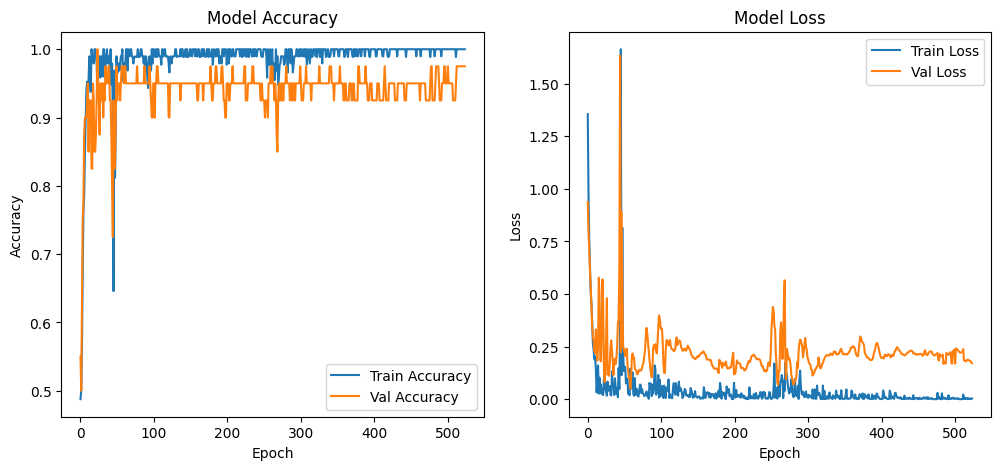

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# plt.tight_layout()
if save_artifacts: plt.savefig(f"{filename}_train.png")
plt.show()


Optionally save the weights of the model

In [ ]:
# optionally save the model weights
if save_artifacts: model.save(f"{filename}.keras")

Evaluate model and print scores

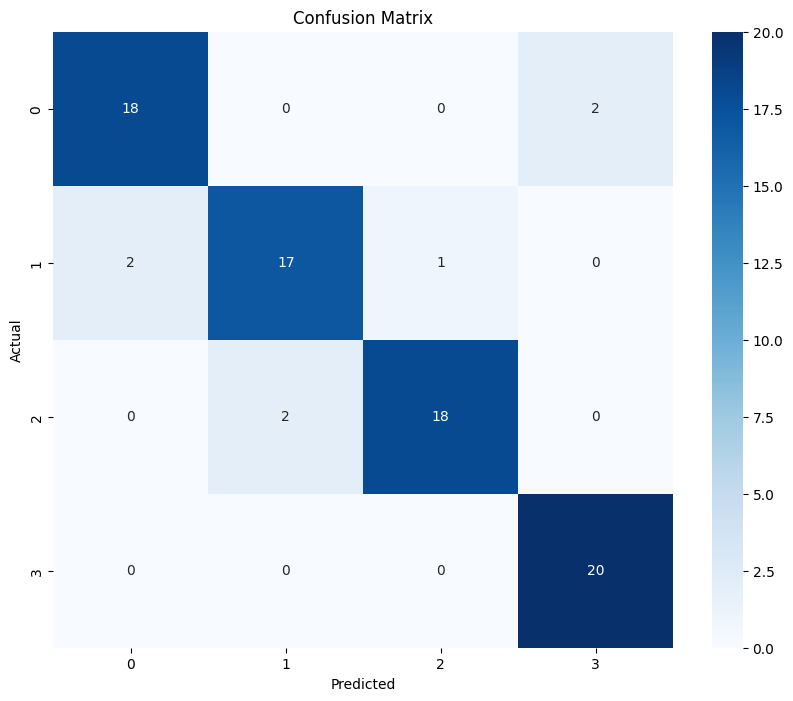

In [ ]:
if save_artifacts:
    f = open(f"{filename}.txt", "w")
    ostd = sys.stdout
    sys.stdout = f

# Summary of the model
model.summary(print_fn = f.write if save_artifacts else None)

# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Classification report and F1 score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if save_artifacts: plt.savefig(f"{filename}.png")
plt.show()


# === Preview Predictions ===
for i in range(min(80, len(y_pred))):
    print(f"True: {y_test[i]}, Pred: {y_pred[i]}, Prob: {predictions[i]}")

if save_artifacts:
    sys.stdout = ostd
    f.close()

In [ ]:
import numpy as np
import random
import os
import tensorflow as tf
from preprocessor import Preprocessor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from test_models import load_model, test_random_line

In [ ]:
# preprocessor_path = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"
test_preprocessor_path = "../data/preprocessors/preprocessor_3_newest_files_100lpc_20ws_BERTencx16.zip"
test_pp = Preprocessor.load(test_preprocessor_path)
print(test_pp.data.states_counts)
test_X, test_y = test_pp.data.as_xy_arrays()

defaultdict(<class 'int'>, {np.int64(0): 100, np.int64(3): 100, np.int64(2): 100, np.int64(1): 30})


In [ ]:
# Get predictions
y_pred_probs = model.predict(test_X)
y_pred = y_pred_probs.argmax(axis=1)  # For softmax outputs

# True labels
y_true = test_y.argmax(axis=1) if test_y.ndim > 1 else test_y

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

if save_artifacts:
    f = open(f"{filename}.txt", "w")
    ostd = sys.stdout
    sys.stdout = f

print("test with test data (3 newest files)")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

if save_artifacts:
    f.close()
    sys.stdout = ostd

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step


d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


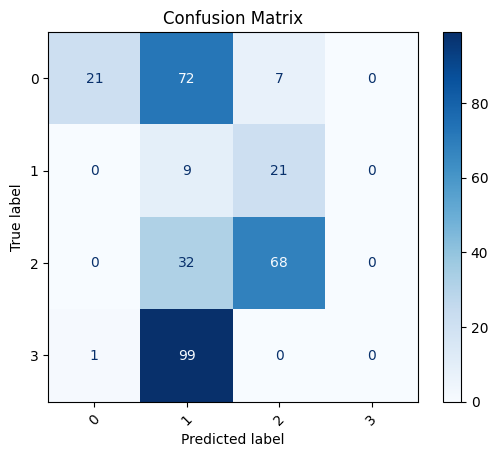

In [ ]:
# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
if save_artifacts: plt.savefig(f"{filename}_test-confusionmatrix.png")
plt.show()